In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# This is to supress the warning messages
import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pd.read_csv(r"C:\Users\Owner\Downloads\Statistics\CPSData.csv")
df = df.dropna().reset_index(drop=True)

In [39]:
df_National = df[(df['EmploymentStatus']=='Unemployed')].reset_index(drop=True)
df_National.head()

,PeopleInHousehold,Region,State,MetroAreaCode,Age,Married,Sex,Education,Race,Hispanic,CountryOfBirthCode,Citizenship,EmploymentStatus,Industry
0,3,South,Alabama,13820.0,21,Never Married,Male,High school,Black,0,57,"Citizen, Native",Unemployed,Professional and business services
1,4,South,Alabama,13820.0,21,Never Married,Male,"Some college, no degree",Black,0,57,"Citizen, Native",Unemployed,Leisure and hospitality
2,1,South,Alabama,26620.0,27,Never Married,Female,Associate degree,Multiracial,0,57,"Citizen, Native",Unemployed,Trade
3,2,South,Alabama,13820.0,40,Divorced,Female,Bachelor's degree,White,0,57,"Citizen, Native",Unemployed,Educational and health services
4,3,South,Alabama,13820.0,35,Never Married,Male,No high school diploma,White,0,57,"Citizen, Native",Unemployed,Leisure and hospitality


In [40]:
df_National['Sex'].replace(['Male','Female'],[0,1],inplace=True)

In [17]:
#Analysis of Numerical Columns
num_df = df_National.select_dtypes(exclude = 'object').copy()
num_df.head()

,PeopleInHousehold,MetroAreaCode,Age,Sex,Hispanic,CountryOfBirthCode
0,3,13820.0,21,0,0,57
1,4,13820.0,21,0,0,57
2,1,26620.0,27,1,0,57
3,2,13820.0,40,1,0,57
4,3,13820.0,35,0,0,57


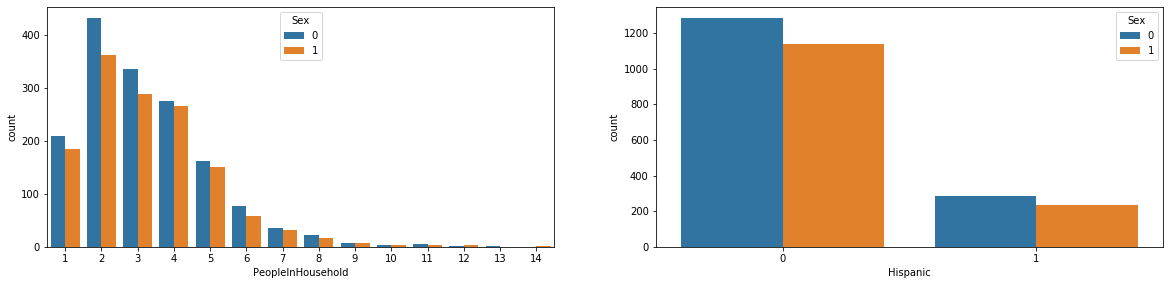

In [18]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(3,2,1) 
sns.countplot(data = df_National, x = 'PeopleInHousehold', ax = ax1,hue='Sex')

ax1 = fig.add_subplot(3,2,2) 
sns.countplot(data = df_National, x = 'Hispanic', ax = ax1,hue='Sex')
plt.show()

In [19]:
#Analysis of Categorical Columns
cat_df = df_National.select_dtypes(include = 'object').copy()
cat_df.head()

,Region,State,Married,Education,Race,Citizenship,EmploymentStatus,Industry
0,South,Alabama,Never Married,High school,Black,"Citizen, Native",Unemployed,Professional and business services
1,South,Alabama,Never Married,"Some college, no degree",Black,"Citizen, Native",Unemployed,Leisure and hospitality
2,South,Alabama,Never Married,Associate degree,Multiracial,"Citizen, Native",Unemployed,Trade
3,South,Alabama,Divorced,Bachelor's degree,White,"Citizen, Native",Unemployed,Educational and health services
4,South,Alabama,Never Married,No high school diploma,White,"Citizen, Native",Unemployed,Leisure and hospitality


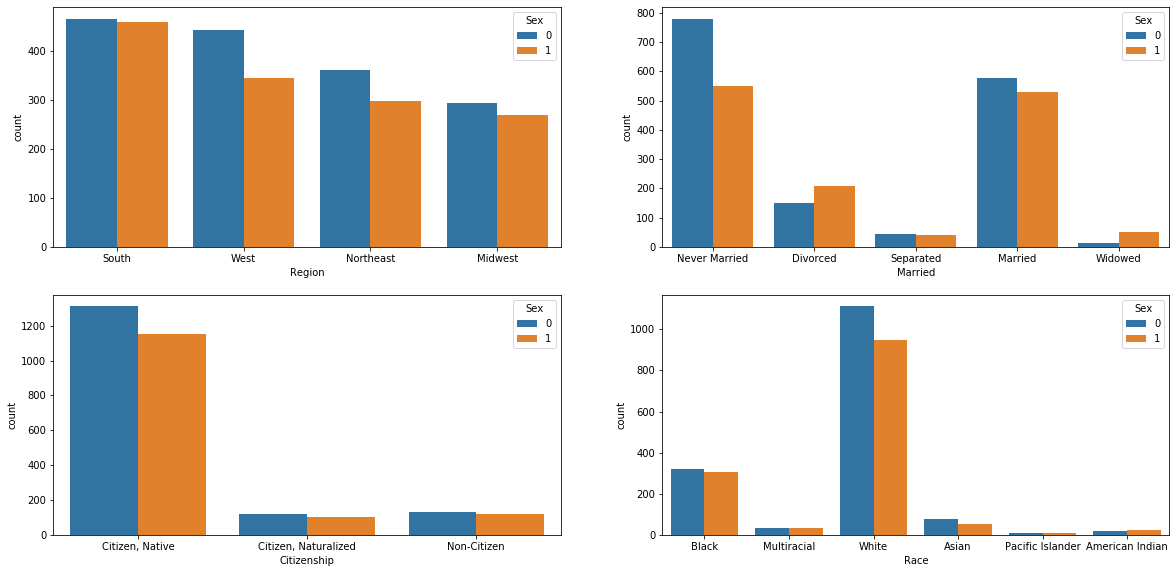

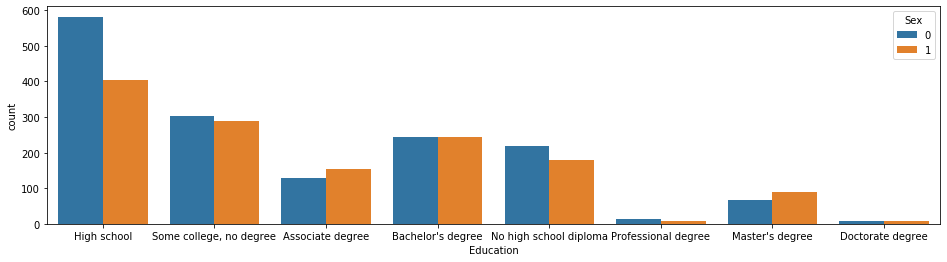

In [20]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(3,2,1) 
sns.countplot(data = df_National, x = 'Region', ax = ax1,hue='Sex')

ax1 = fig.add_subplot(3,2,2) 
sns.countplot(data = df_National, x = 'Married', ax = ax1,hue='Sex')

ax1 = fig.add_subplot(3,2,3) 
sns.countplot(data = df_National, x = 'Citizenship', ax = ax1,hue='Sex')


ax1 = fig.add_subplot(3,2,4) 
sns.countplot(data = df_National, x = 'Race', ax = ax1,hue='Sex')

plt.show()
plt.figure(figsize=(16,4))
sns.countplot(data = df_National, x = 'Education', hue='Sex')
plt.show()

In [21]:
df_National.corr()

,PeopleInHousehold,MetroAreaCode,Age,Sex,Hispanic,CountryOfBirthCode
PeopleInHousehold,1.000000,-0.026787,-0.284486,0.007935,0.219188,0.138480
MetroAreaCode,-0.026787,1.000000,0.031737,0.002856,-0.015511,0.038384
Age,-0.284486,0.031737,1.000000,0.029174,-0.117916,0.073822
Sex,0.007935,0.002856,0.029174,1.000000,-0.013670,-0.012251
Hispanic,0.219188,-0.015511,-0.117916,-0.013670,1.000000,0.324271
CountryOfBirthCode,0.138480,0.038384,0.073822,-0.012251,0.324271,1.000000


In [23]:
#Calculating Weight of Evidence and Information Value for Feature Selection
def get_IV(df, feature, target):
    lst = []
    
    unique_values = df[feature].unique()
    for val in unique_values:
        lst.append([feature,                                                        # Feature name
                    val,                                                            # Value of a feature (unique)
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]   # Bad  (Fraud == 1)
                   ])
 
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'Good', 'Bad'])

        
    total_bad = df[df[target] == 1].count()[feature]
    total_good = df.shape[0] - total_bad
    
    data['Distribution Good'] = data['Good']/ total_good
    data['Distribution Bad'] = data['Bad'] / total_bad
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    iv = data['IV'].sum()
    WoE = data['WoE'].sum()

    return iv, data

In [24]:
df_National_copy = df_National.copy()
final_iv_values = {}

for i in cat_df:
    IV, Data = get_IV(df_National,i,'Hispanic')
    final_iv_values[i] = IV
    for j in range(len(Data)):
        df_National_copy[i] = df_National_copy[i].replace([Data['Value'][j]], Data['WoE'][j])
    
df_National_copy.head()

,PeopleInHousehold,Region,State,MetroAreaCode,Age,Married,Sex,Education,Race,Hispanic,CountryOfBirthCode,Citizenship,EmploymentStatus,Industry
0,3,0.145954,1.956063,13820.0,21,-0.028069,0,-0.115635,1.520941,0,57,0.378809,0.0,0.003906
1,4,0.145954,1.956063,13820.0,21,-0.028069,0,0.247385,1.520941,0,57,0.378809,0.0,-0.021979
2,1,0.145954,1.956063,26620.0,27,-0.028069,1,0.353969,0.200021,0,57,0.378809,0.0,0.017700
3,2,0.145954,1.956063,13820.0,40,0.274380,1,0.649954,-0.296709,0,57,0.378809,0.0,0.265108
4,3,0.145954,1.956063,13820.0,35,-0.028069,0,-0.965955,-0.296709,0,57,0.378809,0.0,-0.021979


In [44]:
#Adding Output Column in x and then removing for Train(X) and y='Output'

X = df_National_copy.drop('Sex', axis=1) # input categorical features
y = df_National_copy['Sex'] # target variable

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components = 1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [49]:
# LR after LDA transformation

classifier_lda = LogisticRegression(random_state=0)
classifier_lda.fit(X_train_lda, y_train)

NameError: name 'LogisticRegression' is not defined